In [16]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 데이터셋 만들기
import keras
from keras.utils import to_categorical

# 얼굴 추적
import cv2
from scipy.ndimage import zoom

import torch

# model

from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import batch_normalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator


# gpu사용 변수
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')


# 데이터 확인
df = pd.read_csv('./data/fer2013/fer2013.csv')

# 이미지 픽셀 list로 만들기
df['pixels'] = df['pixels'].apply(lambda pixel: np.fromstring(pixel, sep=' '))
df.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [17]:
# train test 나누기

train_df = df[df['Usage']=='Training']
test_df = df[df['Usage']=='PublicTest']
print(train_df.shape)
print(test_df.shape)

(28709, 3)
(3589, 3)


In [18]:
shape_x = 48
shape_y = 48

# X_train, y_train, X_test, y_test split
X_train = train_df.iloc[:, 1].values  # pixels
y_train = train_df.iloc[:, 0].values  # emotion

X_test = test_df.iloc[:, 1].values  # pixels
y_test = test_df.iloc[:, 0].values  # emotion

# 전체데이터
X = df.iloc[:, 1].values # pixels
y = df.iloc[:, 0].values # emotion

# array([array([.....])]) 구조를 바꾸기 위한 np.vstack
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [19]:
# 4차원 데이터셋 만들기 (데이터개수, x축, y축, rgb)
X_train_ds = np.reshape(X_train, (X_train.shape[0], shape_x, shape_y, 1))
y_train_ds = np.reshape(y_train, (y_train.shape[0], 1))

X_test_ds = np.reshape(X_test, (X_test.shape[0], shape_x, shape_y, 1))
y_test_ds = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_ds.shape, y_train_ds.shape)
print(X_test_ds.shape, y_test_ds.shape)

(28709, 48, 48, 1) (28709, 1)
(3589, 48, 48, 1) (3589, 1)


In [20]:
# 데이터 타입 float로 변겨
train_data = X_train_ds.astype('float32')
test_data = X_test_ds.astype('float32')

# 스케일링
train_data /= 225
test_data /= 225

# y데이터 원핫인코딩
train_labels_onehot = to_categorical(y_train_ds)
test_labels_onehot = to_categorical(y_test_ds)

# input_shape 설정
n_rows, n_cols, n_dims = X_train_ds.shape[1:]
input_shape = (n_rows, n_cols, n_dims)
print(input_shape)

(48, 48, 1)


Text(0.5, 1.0, 'Ground Truth : happy')

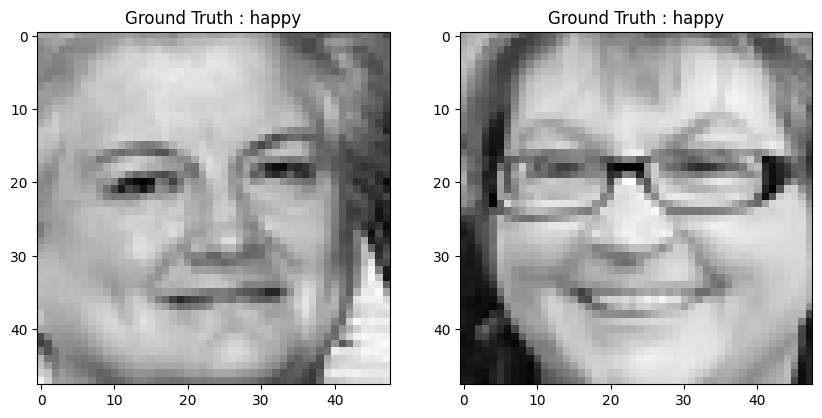

In [21]:
# 라벨 숫자를 문자로 변경
def get_label(argument):
    labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy',
              4:'sad', 5:'surprise', 6:'neutral'}
    return(labels.get(argument, 'Invalid emotion'))
   
# 데이터 시각화
plt.figure(figsize=[10,5])

# Train data 중 100번째 이미지
n=100

plt.subplot(121)
plt.imshow(np.squeeze(X_train_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[n]))))

# Test data 중 100번째 이미지
plt.subplot(122)
plt.imshow(np.squeeze(X_test_ds[n,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[n]))))



In [22]:
# 전체 이미지에서 얼굴을 찾아내는 함수
def detect_face(frame):
    
    # cascade pre-trained 모델 불러오기
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # RGB를 gray scale로 바꾸기
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # cascade 멀티스케일 분류
    detected_faces = face_cascade.detectMultiScale(gray,
                                                   scaleFactor = 1.1,
                                                   minNeighbors = 6,
                                                   minSize = (shape_x, shape_y),
                                                   flags = cv2.CASCADE_SCALE_IMAGE
                                                  )
    
    coord = []
    for x, y, w, h in detected_faces:
        if w > 100:
            sub_img = frame[y:y+h, x:x+w]
            coord.append([x, y, w, h])
            
    return gray, detected_faces, coord

In [28]:
# 전체 이미지에서 찾아낸 얼굴을 추출하는 함수
def extract_face_features(gray, detected_faces, coord, offset_coefficients=(0.075, 0.05)):
    new_face = []
    for det in detected_faces:
        
        # 얼굴로 감지된 영역
        x, y, w, h = det
        
        # 이미지 경계값 받기
        horizontal_offset = int(np.floor(offset_coefficients[0] * w))
        # np.int가 버전 변경으로 int로 변경됨
        vertical_offset = int(np.floor(offset_coefficients[1] * h))
        
        # gray scacle 에서 해당 위치 가져오기
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
        
        # 얼굴 이미지만 확대
        new_extracted_face = zoom(extracted_face, (shape_x/extracted_face.shape[0], shape_y/extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max()) # sacled
        new_face.append(new_extracted_face)
        
    return new_face

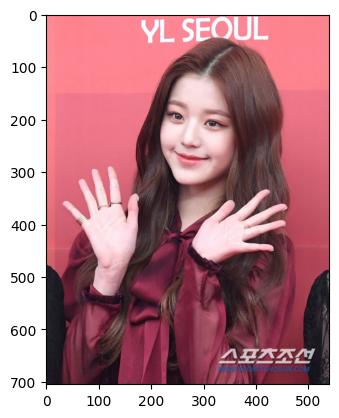

In [31]:
won_image = cv2.imread('./data/images/jang.jpg')
plt.imshow(cv2.cvtColor(won_image, cv2.COLOR_BGR2RGB))

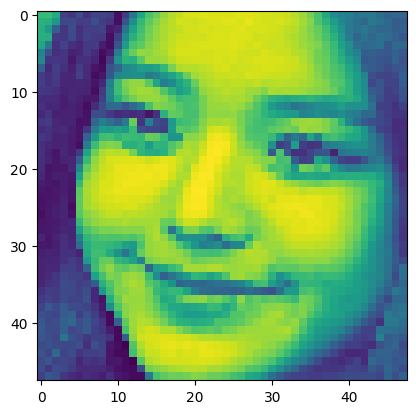

In [32]:
# 얼굴 찾기
gray, detected_faces, coord = detect_face(won_image)

# 찾은 얼굴 추출하기
face_zoom = extract_face_features(gray, detected_faces, coord)

# 시각화
plt.imshow(face_zoom[0])

여기까지가 데이터를 확인하고 얼굴 추출 과정이 잘 동작하는지 확인하는 과정
이후부터는 멀티모달 모델 학습과정
1. 초반에 받았던 fer2013.csv 파일 안에 있는 이미지 픽셀들로부터 얼굴을 추출하고
2. 추출한 얼굴들을 input data로 넣어서 output으로 감정 분석을 할 수 있도록 학습
3. 학습한 모델을 로컬에 저장해 웹캠 실행 시 들어오는 비디오 데이터를 모델의 input으로 받을 수 있게 하여 웹캠에서 실시간으로 감정분석

# 감정분석 단순모델 구축

In [33]:
def simple_model():
    model=Sequential()
    
    # Input layer
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
 
    # Add layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    # Flatten
    model.add(Flatten())
    
    # Fully connected layer
    model.add(Dense(512, activation='relu'))
    
    # Output layer : n_classes=7
    model.add(Dense(7, activation='softmax'))
    
    return model

In [34]:
model = simple_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 21, 21, 64)        36928     
                                                        

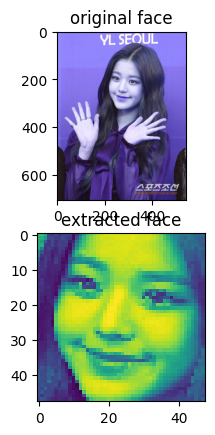

In [38]:
# 각 레이어마다 어떻게 변화하는지 시각화

# 마지막 Dense 레이어 2개를 제외한 레이어별 out 담기
layer_outputs = [layer.output for layer in model.layers[:12]]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# 시각화할 때 어떤 레이어인지 확인할 수 있도록 레이어 이름 담기
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name)

# 장원영 얼굴 이미지 가져오기
won_image = cv2.imread('./data/images/jang.jpg')
gray, detected_faces, coord = detect_face(won_image)
face_zoom = extract_face_features(gray, detected_faces, coord)
face = face_zoom[0]

plt.subplot(211)
plt.title('original face')
plt.imshow(won_image)

plt.subplot(212)
plt.title('extracted face')
plt.imshow(face)

plt.show()

1/1 [==============================] - 0s 20ms/step


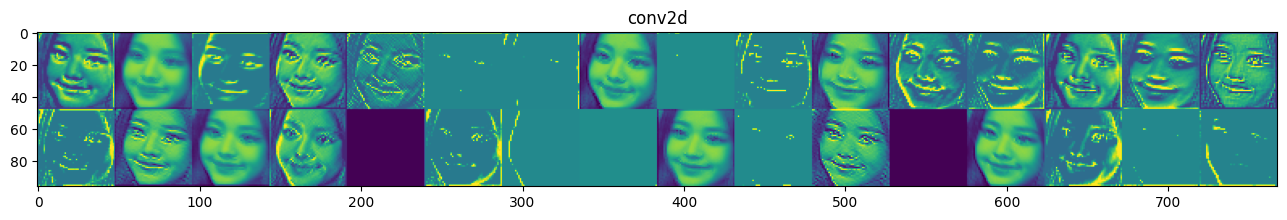

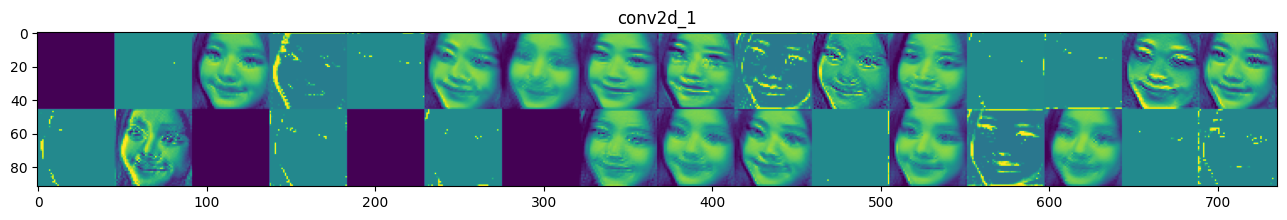

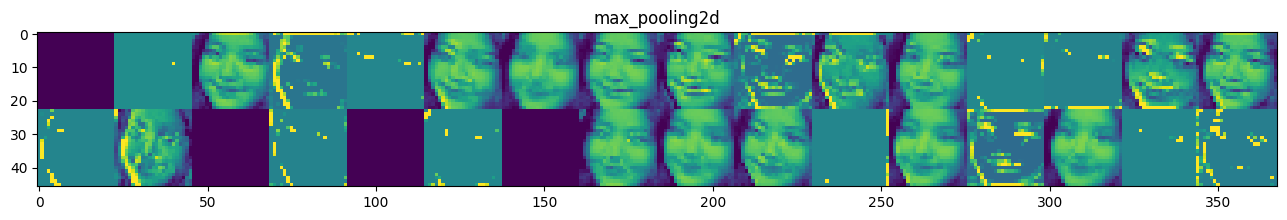

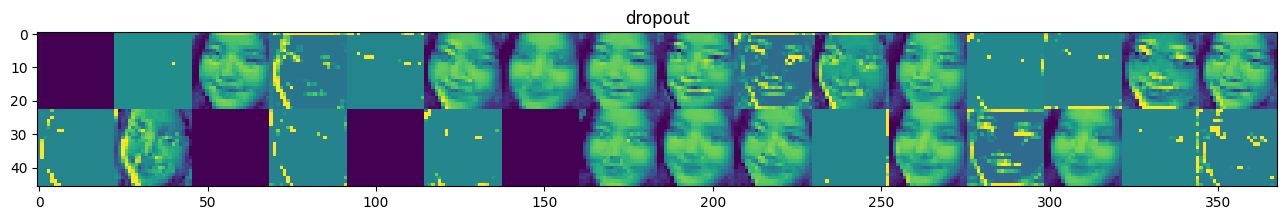

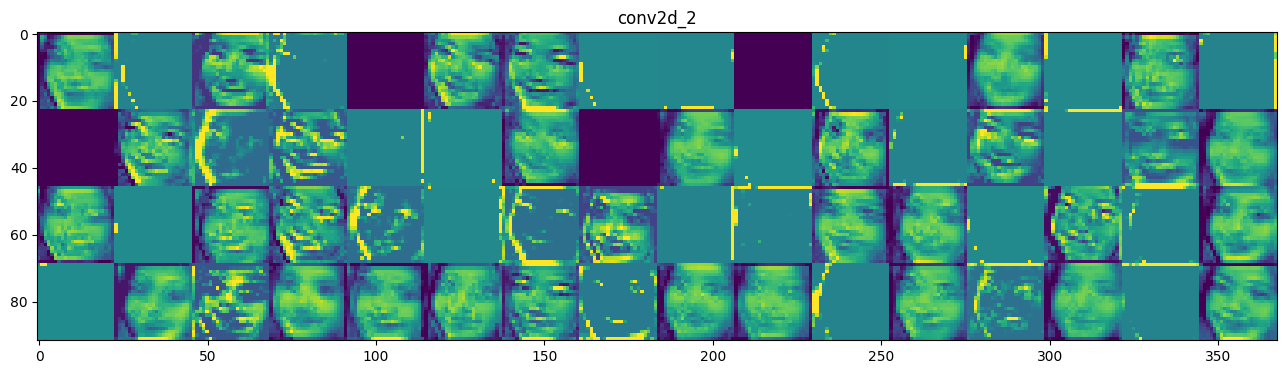

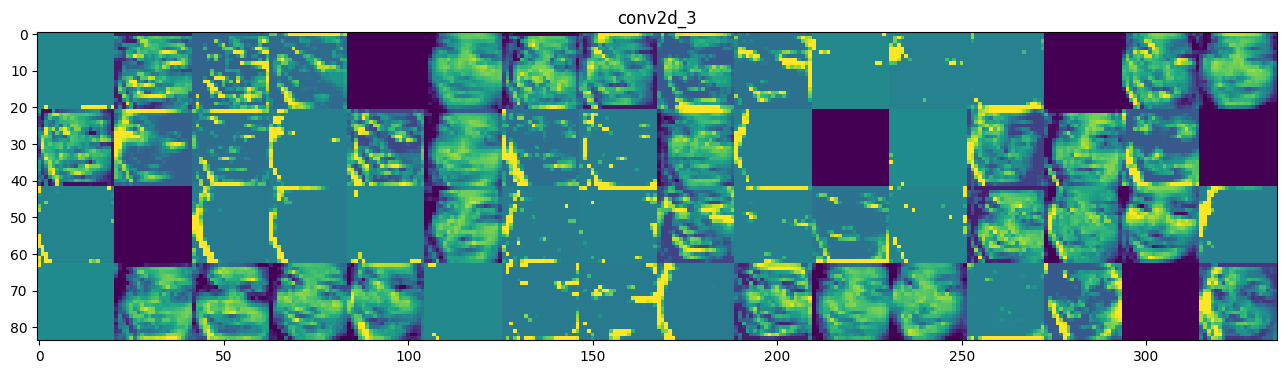

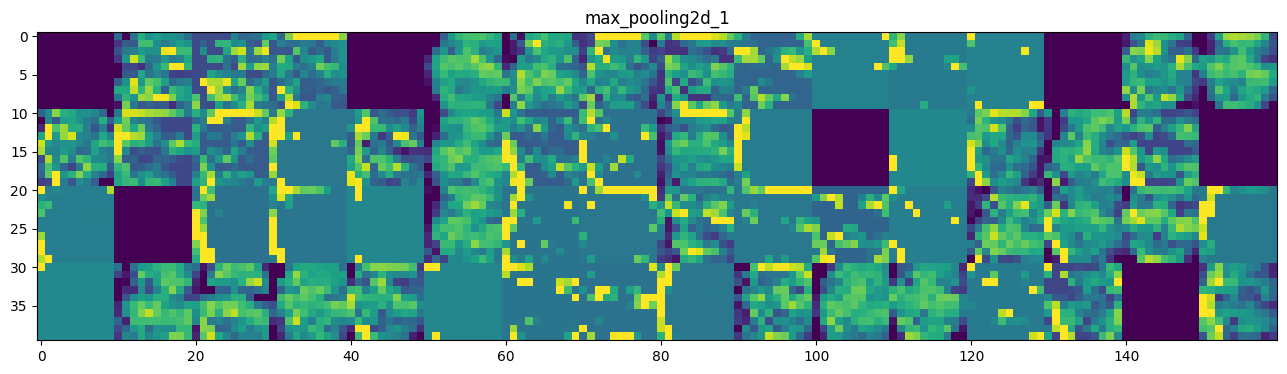

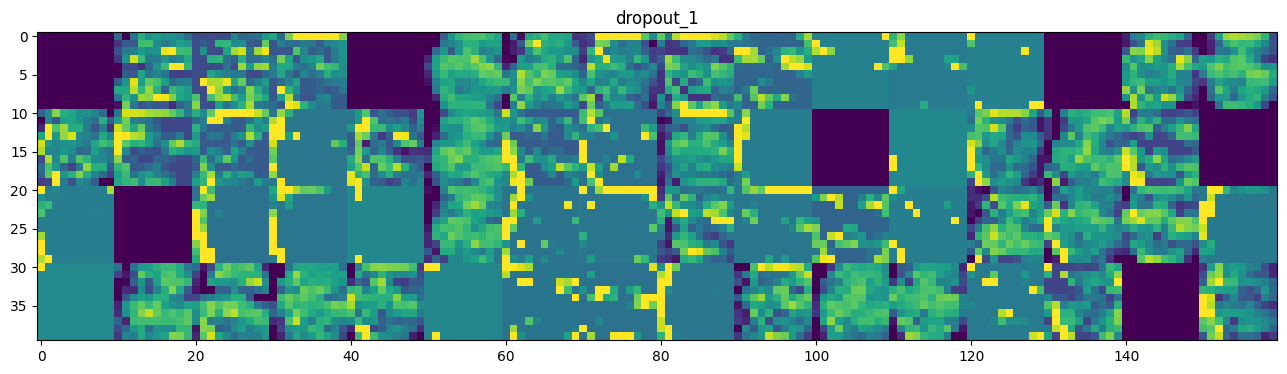

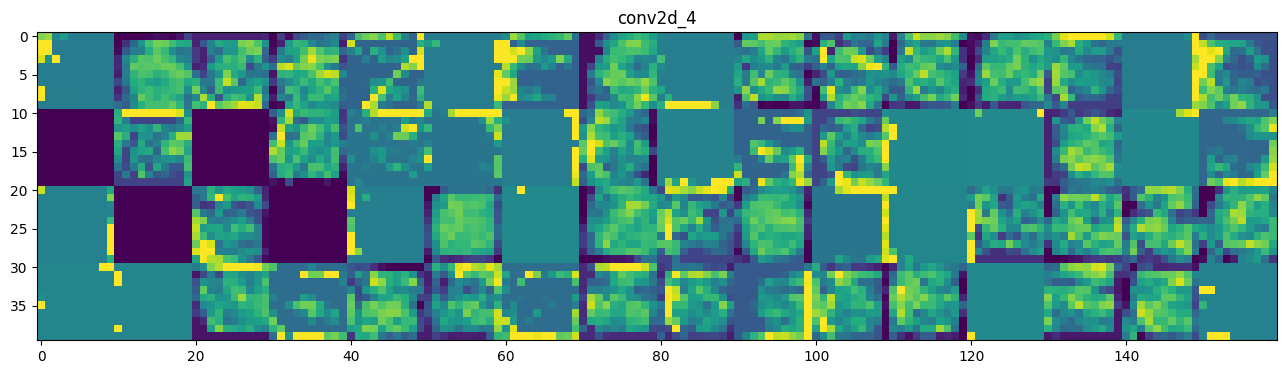

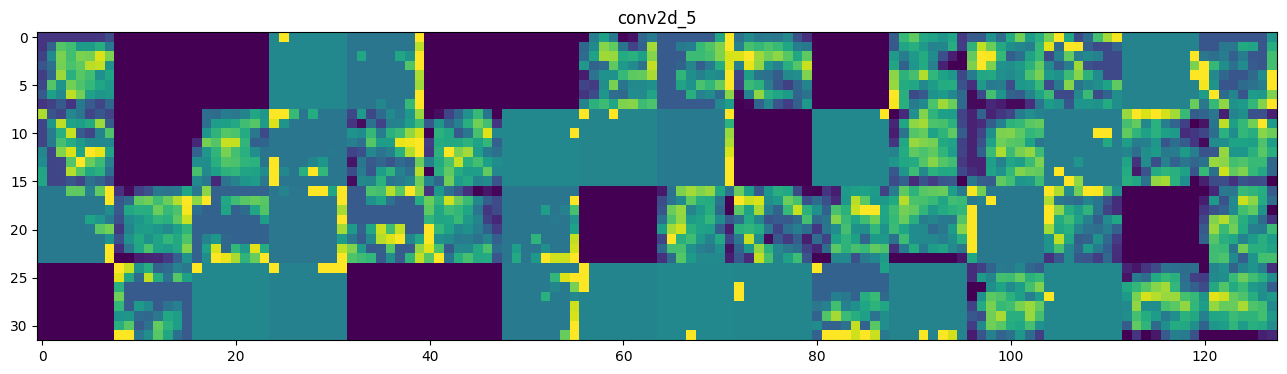

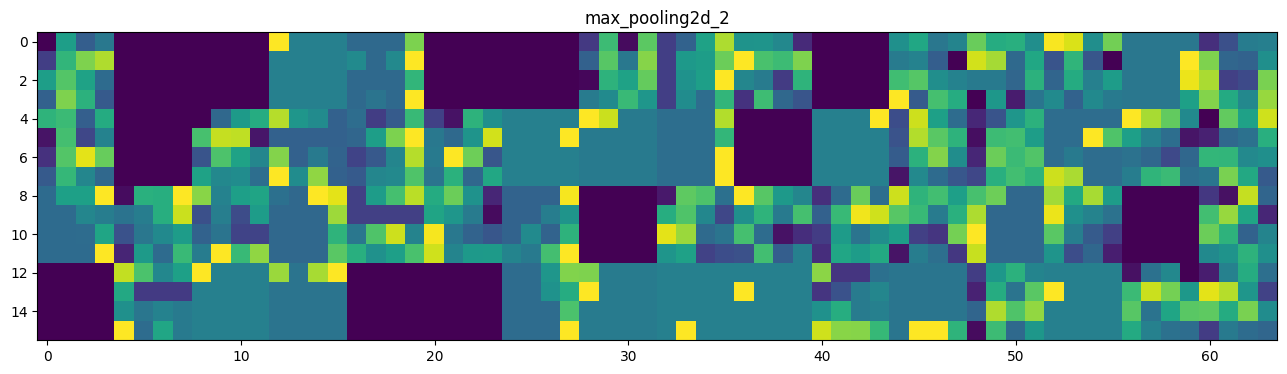

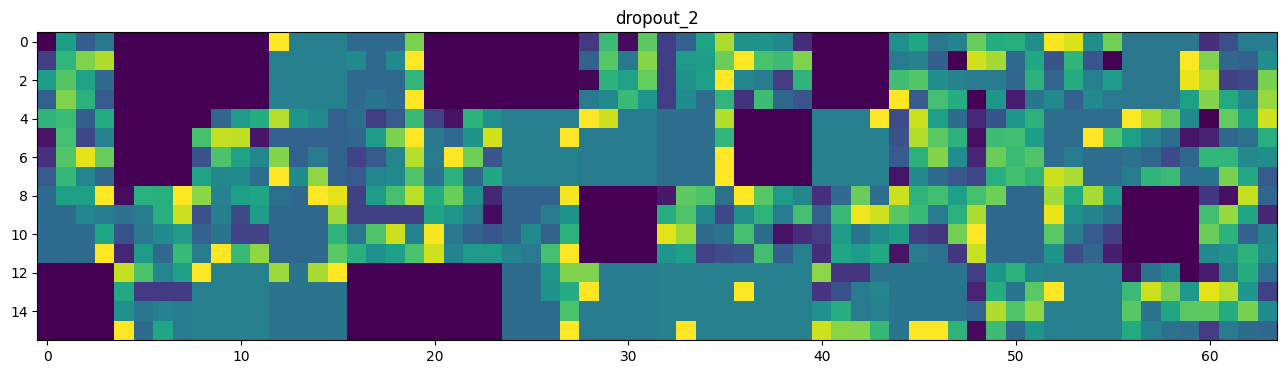

In [40]:
# 장원영 얼굴을 모델에 넣어서 모델이 어떻게 작동하는지 시각화
to_predict = np.reshape(face.flatten(), (1,48,48,1))
res = model.predict(to_predict)
activations = activation_model.predict(to_predict)

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,:, :,col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [42]:
# 이미지 데이터 증강
datagen = ImageDataGenerator(zoom_range=0.2,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)

# 모델 학습을 위한 파라미터 설정
batch_size = 256
n_epochs = 100
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(datagen.flow(train_data, train_labels_onehot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0]/float(batch_size))),
                              epochs=n_epochs,
                              validation_data=(test_data, test_labels_onehot)
)

Epoch 1/100
113/113 [==============================] - 16s 113ms/step - loss: 1.8155 - accuracy: 0.2503 - val_loss: 1.7790 - val_accuracy: 0.2586
Epoch 2/100
113/113 [==============================] - 13s 115ms/step - loss: 1.7550 - accuracy: 0.2774 - val_loss: 1.6677 - val_accuracy: 0.3408
Epoch 3/100
113/113 [==============================] - 14s 120ms/step - loss: 1.6815 - accuracy: 0.3237 - val_loss: 1.5551 - val_accuracy: 0.4076
Epoch 4/100
113/113 [==============================] - 13s 116ms/step - loss: 1.5930 - accuracy: 0.3776 - val_loss: 1.4216 - val_accuracy: 0.4517
Epoch 5/100
113/113 [==============================] - 13s 111ms/step - loss: 1.4913 - accuracy: 0.4219 - val_loss: 1.3923 - val_accuracy: 0.4592
Epoch 6/100
113/113 [==============================] - 13s 118ms/step - loss: 1.4185 - accuracy: 0.4554 - val_loss: 1.2859 - val_accuracy: 0.5063
Epoch 7/100
113/113 [==============================] - 14s 122ms/step - loss: 1.3689 - accuracy: 0.4724 - val_loss: 1.2304 -

Text(0.5, 1.0, 'Accuracy Curves')

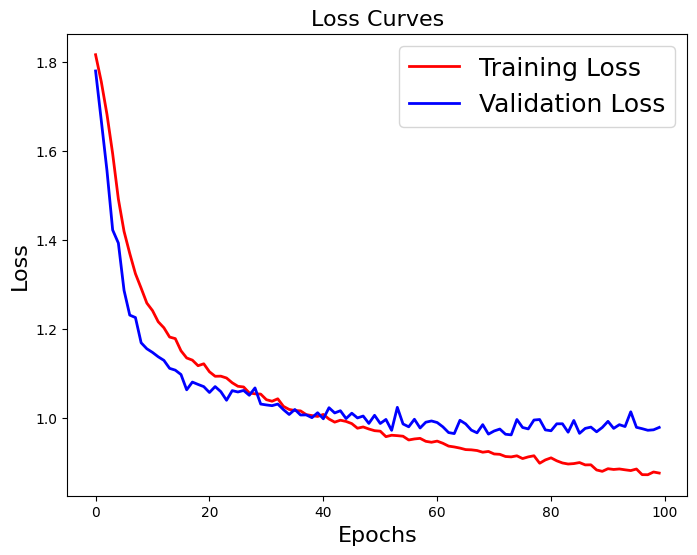

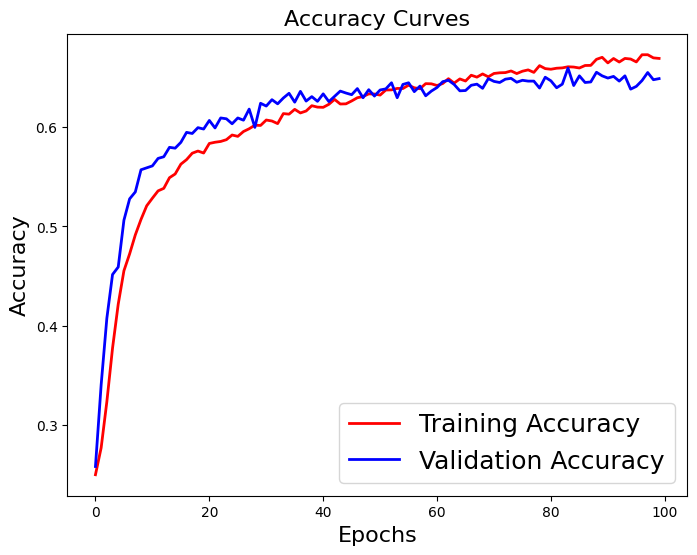

In [43]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'r', linewidth=2.0)
plt.plot(history.history['val_loss'], 'b', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'r', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)


1/1 [==============================] - 0s 17ms/step


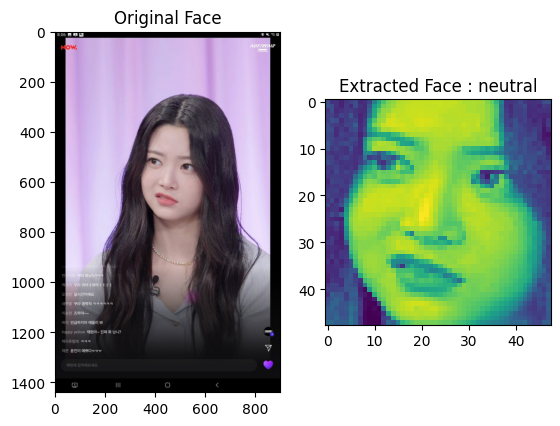

In [49]:
## 감정분석 모델 결과 확인
## 결과 확인을 위해서 인터넷에서 돌아다니는 연예인 사진을 모아서 별도 저장한 뒤
## face 변수에 넣어 모델 결과를 확인

# 원본이미지 확인
face = cv2.imread('./data/images/anger.jpg')

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

1/1 [==============================] - 0s 16ms/step


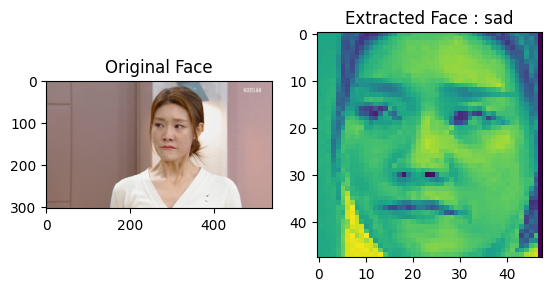

In [46]:
## 감정분석 모델 결과 확인
## 결과 확인을 위해서 인터넷에서 돌아다니는 연예인 사진을 모아서 별도 저장한 뒤
## face 변수에 넣어 모델 결과를 확인

# 원본이미지 확인
face = cv2.imread('./data/images/sadbutanger.jpg')

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

1/1 [==============================] - 0s 14ms/step


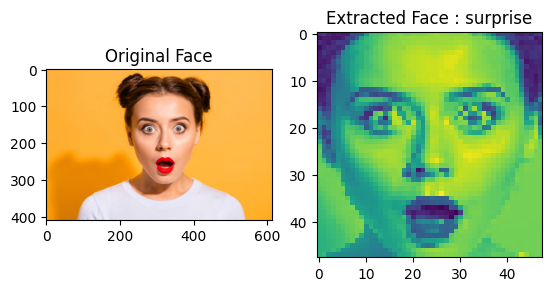

In [47]:
## 감정분석 모델 결과 확인
## 결과 확인을 위해서 인터넷에서 돌아다니는 연예인 사진을 모아서 별도 저장한 뒤
## face 변수에 넣어 모델 결과를 확인

# 원본이미지 확인
face = cv2.imread('./data/images/sur.jpg')

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

1/1 [==============================] - 0s 16ms/step


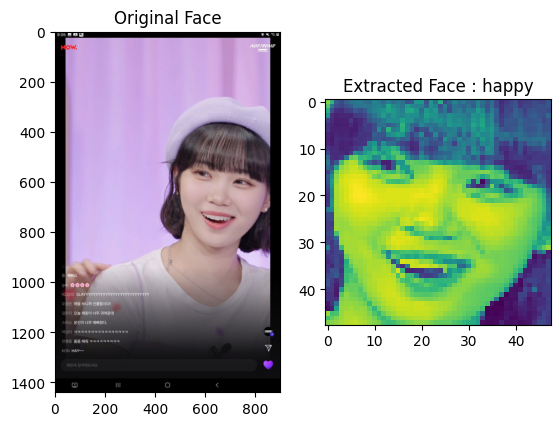

In [50]:
## 감정분석 모델 결과 확인
## 결과 확인을 위해서 인터넷에서 돌아다니는 연예인 사진을 모아서 별도 저장한 뒤
## face 변수에 넣어 모델 결과를 확인

# 원본이미지 확인
face = cv2.imread('./data/images/smile.jpg')

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])

1/1 [==============================] - 0s 30ms/step


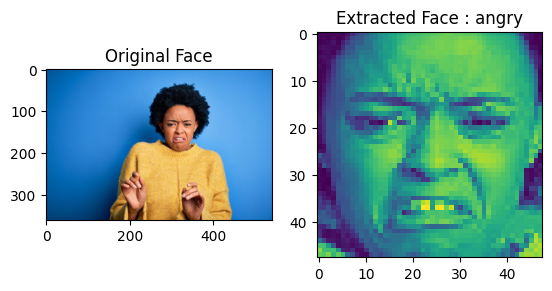

In [53]:
## 감정분석 모델 결과 확인
## 결과 확인을 위해서 인터넷에서 돌아다니는 연예인 사진을 모아서 별도 저장한 뒤
## face 변수에 넣어 모델 결과를 확인

# 원본이미지 확인
face = cv2.imread('./data/images/disgust.jpg')

# 얼굴 추출
gray, detected_faces, coord = detect_face(face)
face_zoom = extract_face_features(gray, detected_faces, coord)

# 모델 추론
input_data = np.reshape(face_zoom[0].flatten(), (1, 48, 48, 1))
output_data = model.predict(input_data)
result = np.argmax(output_data)

# 결과 문자로 변환
if result == 0:
    emotion = 'angry'
elif result == 1:
    emotion = 'disgust'
elif result == 2:
    emotion = 'fear'
elif result == 3:
    emotion = 'happy'
elif result == 4:
    emotion = 'sad'
elif result == 5:
    emotion = 'surprise'
elif result == 6:
    emotion = 'neutral'
    
# 시각화
plt.subplot(121)
plt.title("Original Face")
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))

plt.subplot(122)
plt.title(f"Extracted Face : {emotion}")
plt.imshow(face_zoom[0])